In [1]:
#Importando as bibliotecas
import cv2
import matplotlib.pyplot as plt
import matplotlib
import random
from random import randint

import numpy as np

matplotlib.style.use('dark_background')
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
matplotlib.rcParams['image.cmap'] = 'gray'
#%matplotlib inline

DATA_PATH = r"D:\Estudos\OpenCV\Computer Vision - Introduction\w9 - Video Analysis\data"

In [2]:
faceCascade = cv2.CascadeClassifier(DATA_PATH + '/models/haarcascade_frontalface_default.xml')

In [9]:
#filename = DATA_PATH + '/videos/face1.mp4'
# Inicializar a captura de vídeo da câmera
cap = cv2.VideoCapture(0)

ret, frame = cap.read()

frameGray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faces = faceCascade.detectMultiScale(frameGray, 1.3, 5)
x,y,w,h = faces[0]

currWindow = (x,y,w,h)

In [10]:
# get the face region from the frame
roiObject = frame[y:y+h,x:x+w]

hsvObject =  cv2.cvtColor(roiObject, cv2.COLOR_BGR2HSV)

# Get the mask for calculating histogram of the object and
# also remove noise
mask = cv2.inRange(hsvObject, np.array((0., 50., 50.)),
                   np.array((180.,255.,255.)))

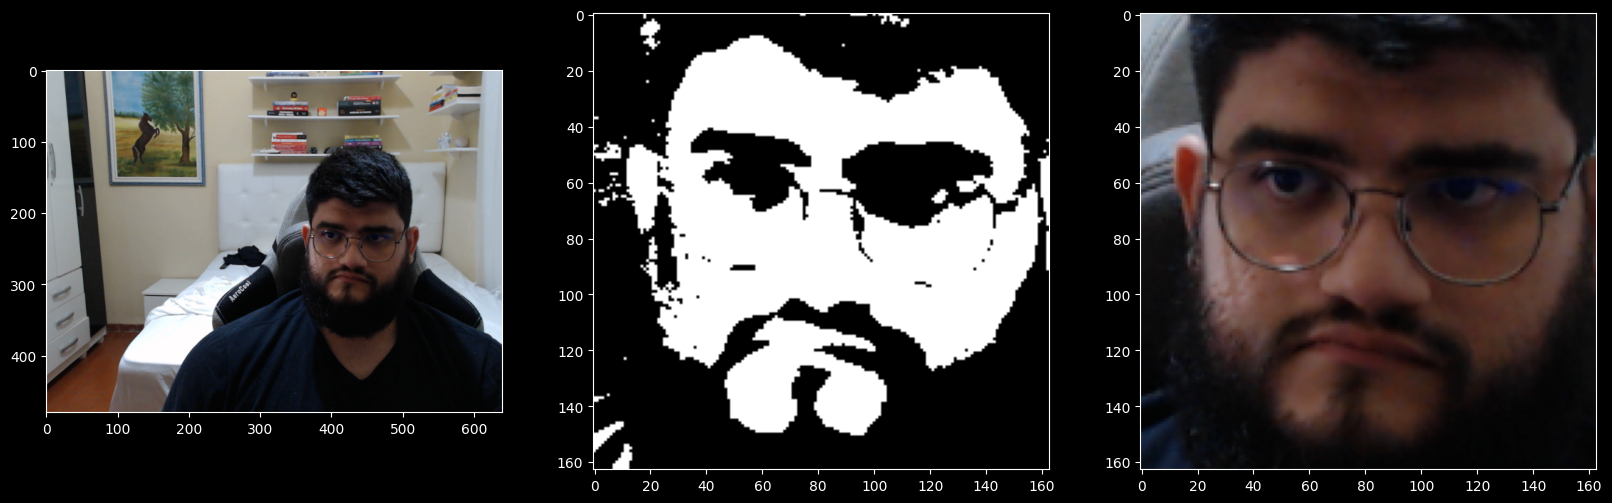

In [11]:
plt.figure(figsize = (20,8))
plt.subplot(131)
plt.imshow(frame[:,:,::-1], cmap ='gray')

plt.subplot(132)
plt.imshow(mask, cmap ='gray')

plt.subplot(133)
plt.imshow(roiObject[:,:,::-1], cmap ='gray')
plt.show()

## Meanshift Tracking

In [12]:
# Inicializar a captura de vídeo da câmera
cap = cv2.VideoCapture(0)

while True:
    # Ler o próximo quadro da câmera
    ret, frame = cap.read()

    # Converter o quadro para escala de cinza
    frameGray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detectar rostos no quadro
    faces = faceCascade.detectMultiScale(frameGray, 1.3, 5)

    if len(faces) > 0:
        # Obter as coordenadas do primeiro rosto detectado
        x, y, w, h = faces[0]

        # Extrair a região do rosto do quadro
        roiObject = frame[y:y+h, x:x+w]

        # Converter para o espaço de cores HSV
        hsvObject = cv2.cvtColor(roiObject, cv2.COLOR_BGR2HSV)

        # Criar uma máscara para calcular o histograma do objeto
        mask = cv2.inRange(hsvObject, np.array((0., 50., 50.)),
                           np.array((180., 255., 255.)))

        # Exibir os resultados
        cv2.imshow("ROI", roiObject)
        cv2.imshow("Mask", mask)

    # Aguarda o pressionamento de uma tecla ou 30 milisegundos
    k = cv2.waitKey(10)
    if k == ord('q') or k == ord('Q') or k == 27:
        break

# Libera a memória do programa
cap.release()
cv2.destroyAllWindows()

In [14]:
# Find the histogram and normalize it to have values
# between 0 to 255
histObject = cv2.calcHist([hsvObject], [0],
                          mask, [180], [0,180])
cv2.normalize(histObject, histObject, 0,
              255, cv2.NORM_MINMAX);

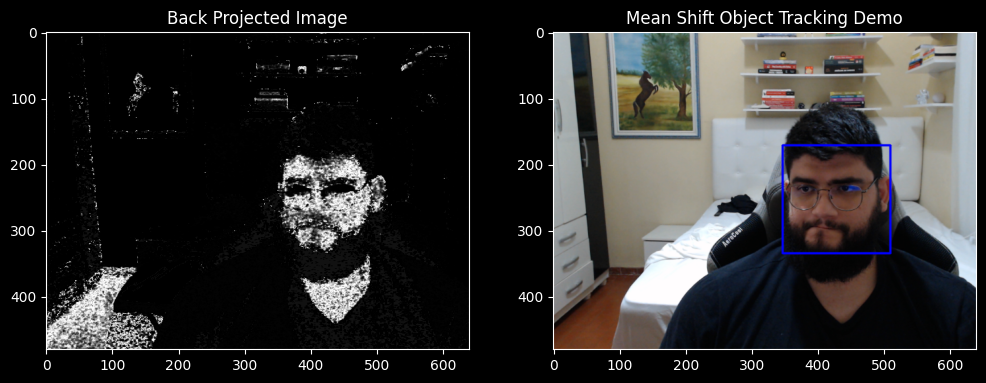

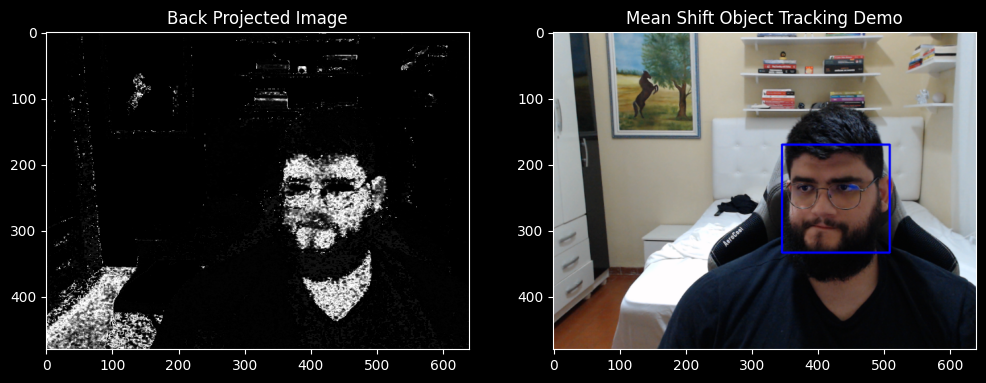

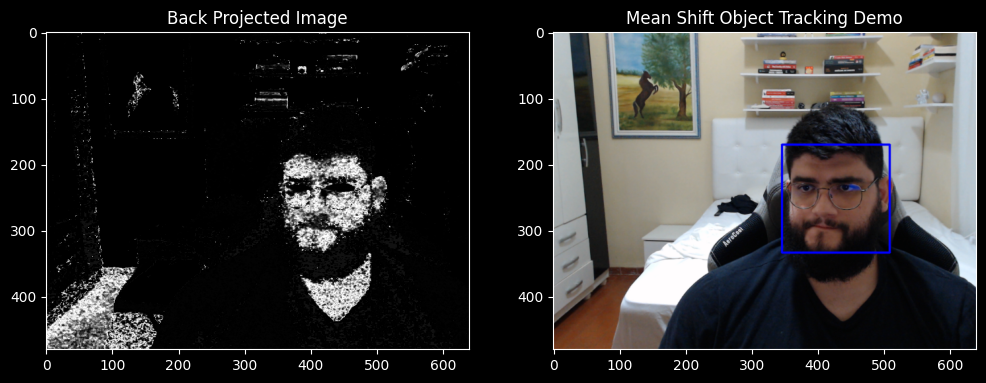

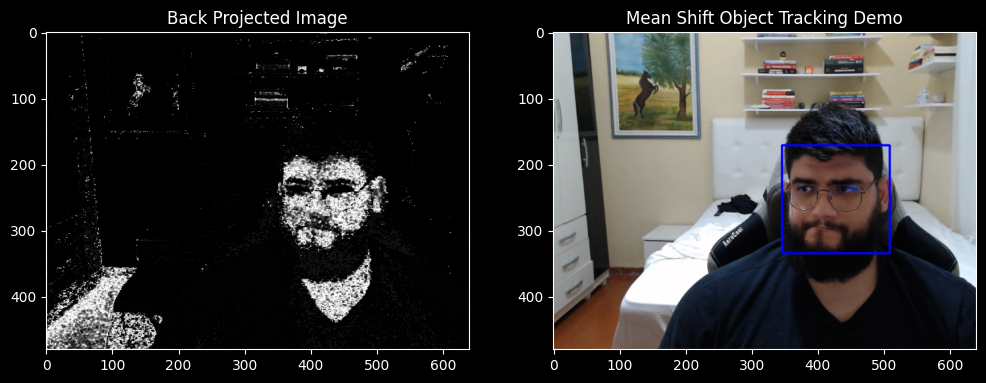

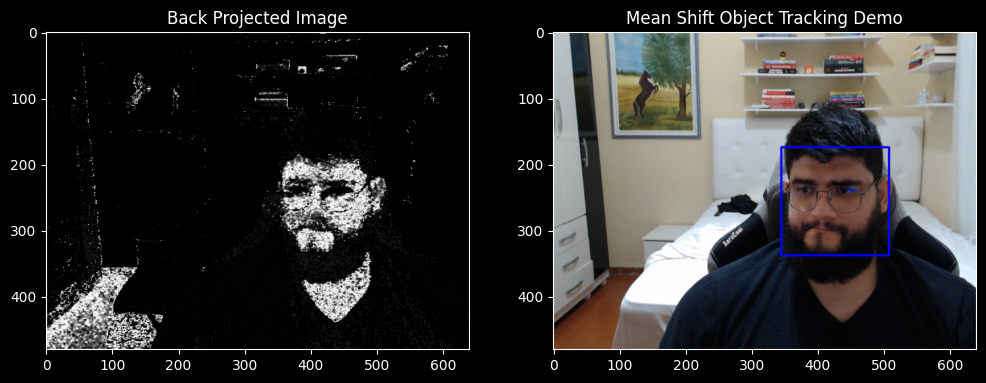

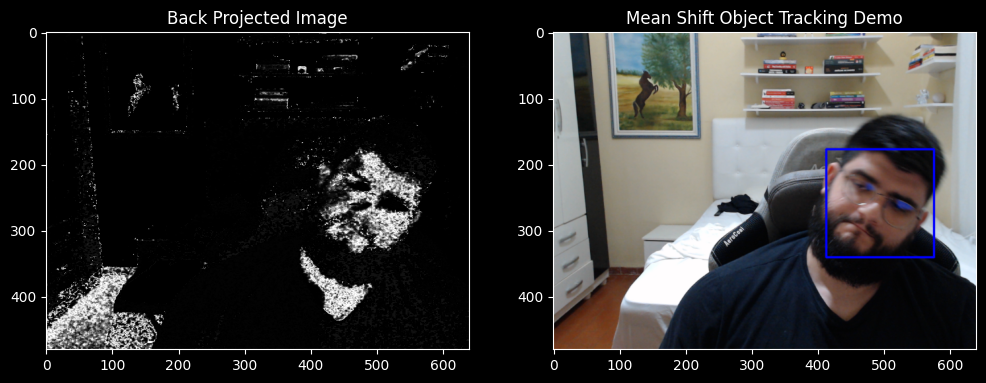

In [15]:
# Setup the termination criteria, either 10 iterations or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

# We will process only first 5 frames
count = 0
while(1):
    ret , frame = cap.read()
    if ret == True:
        # Convert to hsv color space
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # find the back projected image with the histogram obtained earlier
        backProjectImage = cv2.calcBackProject([hsv], [0], histObject, [0,180], 1)

        # Compute the new window using mean shift in the present frame
        ret, currWindow = cv2.meanShift(backProjectImage, currWindow, term_crit)

        # Display the frame with the tracked location of face
        x,y,w,h = currWindow
        frameClone = frame.copy()

        if count % 20 == 0:
            plt.figure(figsize=(12,12))
            plt.subplot(1,2,1)
            plt.imshow(backProjectImage)
            plt.title("Back Projected Image")
            cv2.rectangle(frameClone, (x,y), (x+w,y+h), (255,0,0), 2, cv2.LINE_AA)
            plt.subplot(1,2,2)
            plt.imshow(frameClone[:,:,::-1])
            plt.title('Mean Shift Object Tracking Demo')
            plt.show()
    else:
        break
    count += 1
    if count > 100:
        break

In [ ]:
cap.release()

## Object Tracking using CAMshift

In [18]:
# Find the histogram and normalize it to have values between
# 0 to 255
histObject = cv2.calcHist([hsvObject], [0],
                          mask, [180], [0,180])
cv2.normalize(histObject, histObject,
              0, 255, cv2.NORM_MINMAX);

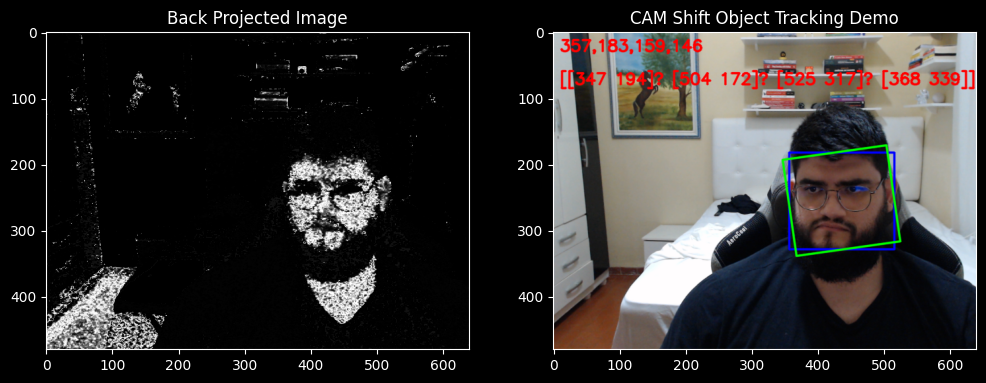

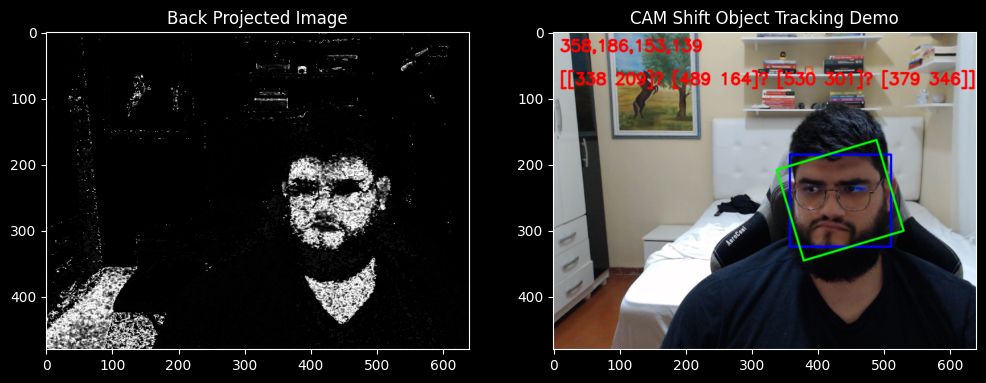

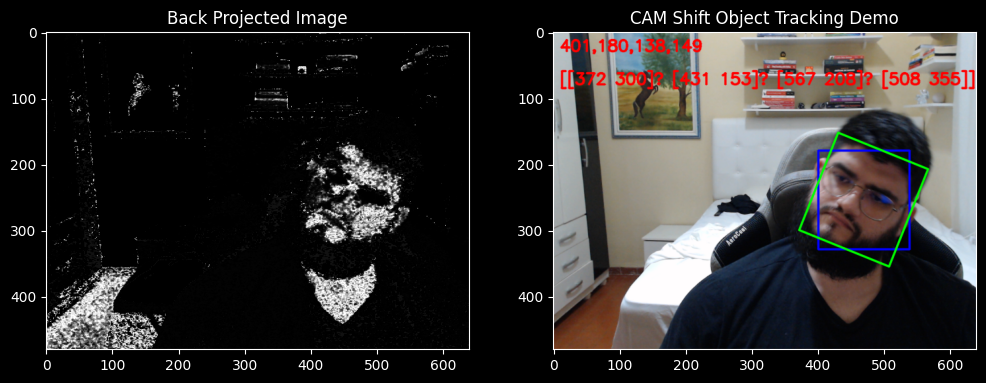

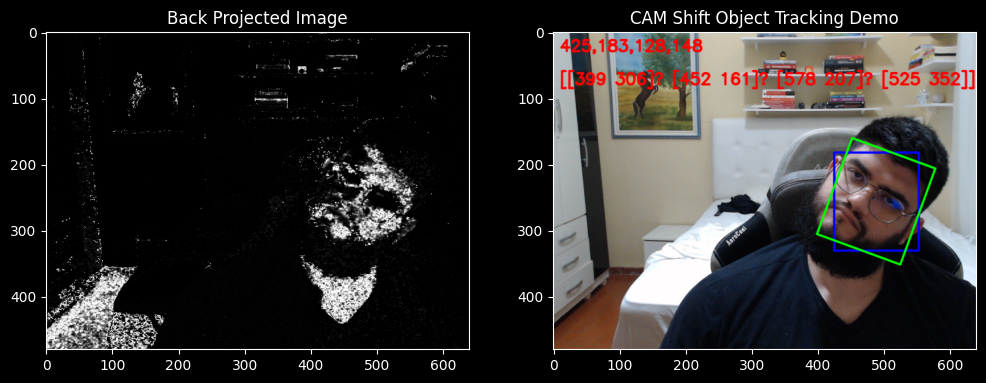

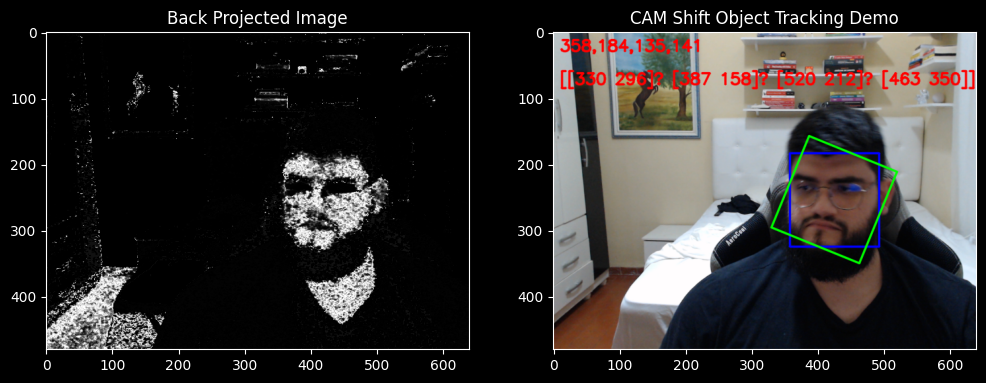

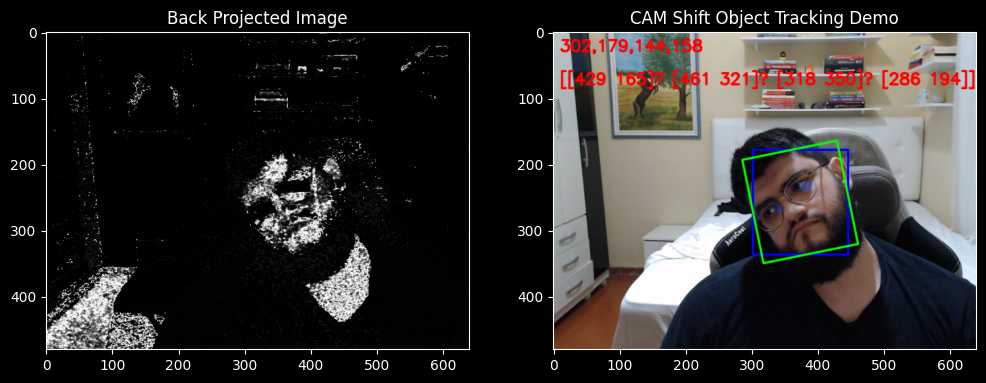

In [19]:
# Setup the termination criteria, either 10 iterations or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
# We will display only first 5 frames
count = 0
i=0
while(1):
    ret, frame = cap.read()
    if ret == True:
        # Convert to hsv color space
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # find the back projected image with the histogram obtained earlier
        backProjectImage = cv2.calcBackProject([hsv], [0], histObject, [0,180], 1)



        # Compute the new window using CAM shift in the present frame
        rotatedWindow, currWindow = cv2.CamShift(backProjectImage, currWindow, term_crit)

        # Get the window used by mean shift
        x,y,w,h = currWindow

        # Get the rotatedWindow vertices
        rotatedWindow = cv2.boxPoints(rotatedWindow)
        rotatedWindow = np.int0(rotatedWindow)
        frameClone = frame.copy()

        # Display the current window used for mean shift
        cv2.rectangle(frameClone, (x,y), (x+w,y+h), (255, 0, 0), 2, cv2.LINE_AA)

        # Display the rotated rectangle with the orientation information
        frameClone = cv2.polylines(frameClone, [rotatedWindow], True, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(frameClone, "{},{},{},{}".format(x,y,w,h), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, .8, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(frameClone, "{}".format(rotatedWindow), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, .8, (0, 0, 255), 2, cv2.LINE_AA)

        if count % 20 == 0:
            plt.figure(figsize=(12,12))
            plt.subplot(1,2,1)
            plt.imshow(backProjectImage)
            plt.title("Back Projected Image")
            plt.subplot(1,2,2)
            plt.imshow(frameClone[:,:,::-1])
            plt.title('CAM Shift Object Tracking Demo')
            plt.show()

        i+=1
    else:
        break
    count += 1
    if count > 100:
        break

In [20]:
cap.release()

https://en.wikipedia.org/wiki/Mean_shift
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html
https://docs.opencv.org/4.1.0/db/df8/tutorial_py_meanshift.html
https://en.wikipedia.org/wiki/Mean_shift
https://fr.wikipedia.org/wiki/Camshift
https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_mean_shift_tracking_segmentation.php
https://www.pyimagesearch.com/wp-content/uploads/2014/11/opencv_crash_course_camshift.pdf
https://www.youtube.com/watch?v=EDT0vHsMy34
https://www.youtube.com/watch?v=a9KZjQ4e6IA